In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = (12,8)

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('trx_estimate.csv')

In [2]:
# optional run to chose how much data you want to take
df = df[:290]

In [3]:
df.tail()

date   trx
285  2021-05-13  4014
286  2021-05-14  4632
287  2021-05-15  3658
288  2021-05-16  2644
289  2021-05-17  3594

In [4]:
# convert to pandas object for further calculations
df['date']=pd.to_datetime(df['date'])

In [5]:
df.set_index('date',inplace=True)
df.index.freq = 'D'
df.head()

trx
date            
2020-08-01  1890
2020-08-02  1835
2020-08-03  2408
2020-08-04  2908
2020-08-05  3207

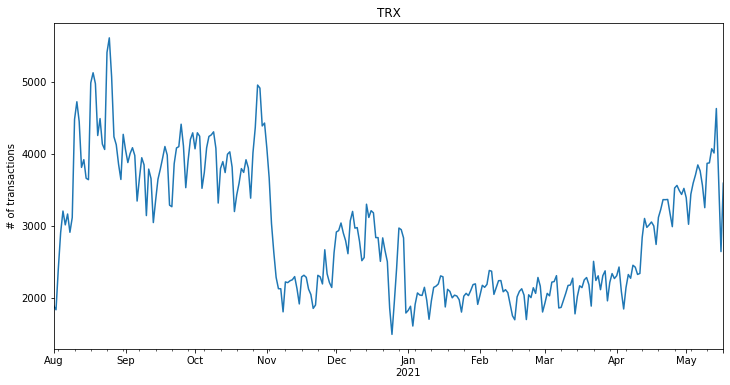

In [6]:
title = 'TRX'
ylabel= '# of transactions'
xlabel= '' # we don't really need a label here

ax = df['trx'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Run an ETS Decomposition

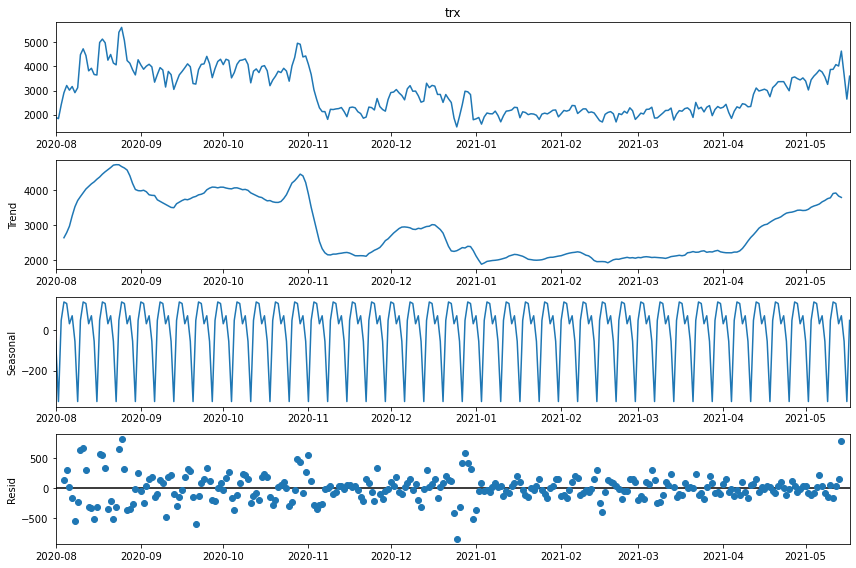

In [7]:
#Allows to see trends and seasonality in time series data
result = seasonal_decompose(df['trx'], model='add')
result.plot();

In [8]:
# For SARIMA Orders we set seasonal=True and pass in an m value which specifies length of seasonality period
auto_arima(df['trx'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  290
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -2005.450
Date:                             Thu, 20 May 2021   AIC                           4026.900
Time:                                     15:40:36   BIC                           4056.231
Sample:                                          0   HQIC                          4038.653
                                             - 290                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -26.9354     22.863     -1.178      0.239     -71.745      17.875
ar.L1         -1.3492      0.108    -12.519      0.000      -1.560      -1.138
ar.L2         -0.7411      0.098     -7.546      0.000      -0.934      -0.549
ma.L1          1.4896      0.102     14.599      0.000       1.290       1.690
ma.L2          0.8347      0.087      9.634      0.000       0.665       1.005
ar.S.L7        0.9056      0.032     28.580      0.000       0.843       0.968
ma.S.L7       -0.4560      0.072     -6.341      0.000      -0.597      -0.315
sigma2      6.299e+04   4237.515     14.864      0.000    5.47e+04    7.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.85
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Split for testing
train = df.iloc[:150]
test = df.iloc[150:]

In [10]:
# Fit model based on SARIMAX resutl from auto_sarima function
model = SARIMAX(train['trx'],order=(2,1,2),seasonal_order=(1,0,1,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 trx   No. Observations:                  150
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -1048.954
Date:                             Thu, 20 May 2021   AIC                           2111.907
Time:                                     15:40:36   BIC                           2132.935
Sample:                                 08-01-2020   HQIC                          2120.450
                                      - 12-28-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7302      0.213      3.426      0.001       0.312       1.148
ar.L2          0.1470      0.213      0.690      0.490      -0.271       0.565
ma.L1         -0.5083      0.242     -2.105      0.035      -0.982      -0.035
ma.L2         -0.4917      0.204     -2.408      0.016      -0.892      -0.092
ar.S.L7        0.9134      0.045     20.107      0.000       0.824       1.002
ma.S.L7       -0.5046      0.110     -4.567      0.000      -0.721      -0.288
sigma2      7.266e+04   2.43e-06   2.99e+10      0.000    7.27e+04    7.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.69
Prob(Q):                              0.98   Prob(JB):                         0.06
Heteroskedasticity (H):               0.47   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.68e+25. Standard errors may be unstable.
"""

In [11]:
# predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,1,2)(1,0,1,7) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

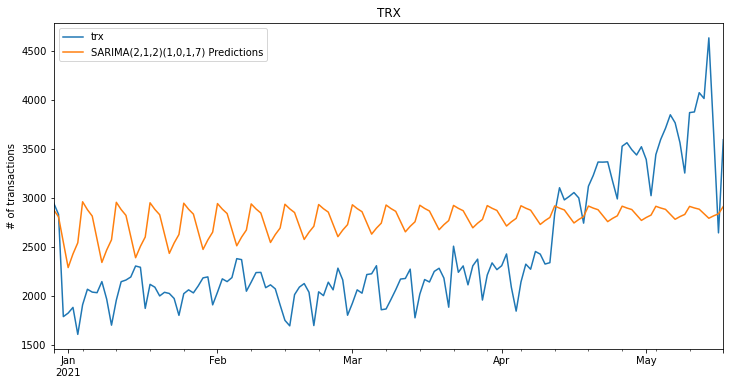

In [12]:
# Plot predictions against known values
title = 'TRX'
ylabel='# of transactions'
xlabel=''

ax = test['trx'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [13]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['trx'], predictions)
print(f' MSE Error: {error:11.10}')

 MSE Error: 470251.0596


In [14]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['trx'], predictions)
print(f'RMSE Error: {error:11.10}')

RMSE Error: 685.7485396


### Retrain the model on the full data, and forecast the future

In [15]:
model = SARIMAX(df['trx'],order=(0,1,3),seasonal_order=(1,0,1,7))
results = model.fit()
fcast = results.predict(len(df),len(df)+90,typ='levels').rename('Forecast')

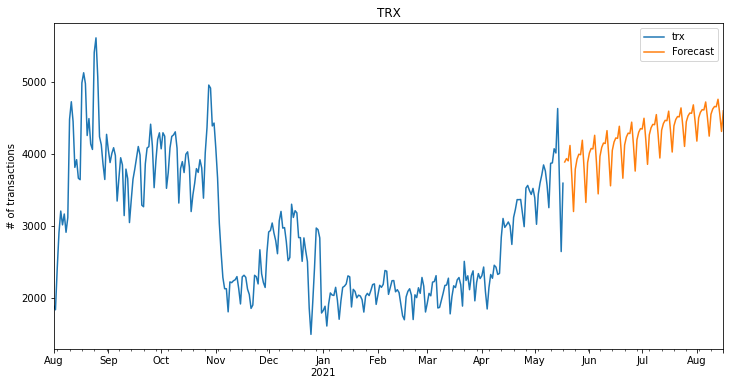

In [16]:
# Plot predictions against known values
title = 'TRX'
ylabel='# of transactions'
xlabel=''

ax = df['trx'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);